<a href="https://colab.research.google.com/github/tommyEzreal/study_low_level/blob/main/NLP/%EB%B0%91%EB%B0%94%EB%8B%A5%EB%B6%80%ED%84%B0%EC%8B%9C%EC%9E%91%ED%95%98%EB%8A%94%EB%94%A5%EB%9F%AC%EB%8B%9D2/chapter04/CBOW_NegativeSampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/WegraLee/deep-learning-from-scratch-2

Cloning into 'deep-learning-from-scratch-2'...
remote: Enumerating objects: 606, done.
remote: Counting objects: 100% (301/301), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 606 (delta 259), reused 245 (delta 245), pack-reused 305
Receiving objects: 100% (606/606), 29.81 MiB | 28.50 MiB/s, done.
Resolving deltas: 100% (374/374), done.


In [ ]:
%cd /content/deep-learning-from-scratch-2

/content/deep-learning-from-scratch-2


**Problem of word2vec**

computing complexity by vocab_size

new layer: **word Embedding**  
new loss fct: negative sampling 

consider vocab_size = 1million, hidden_size = 100   
-> one-hot vec of input dim : 1million 
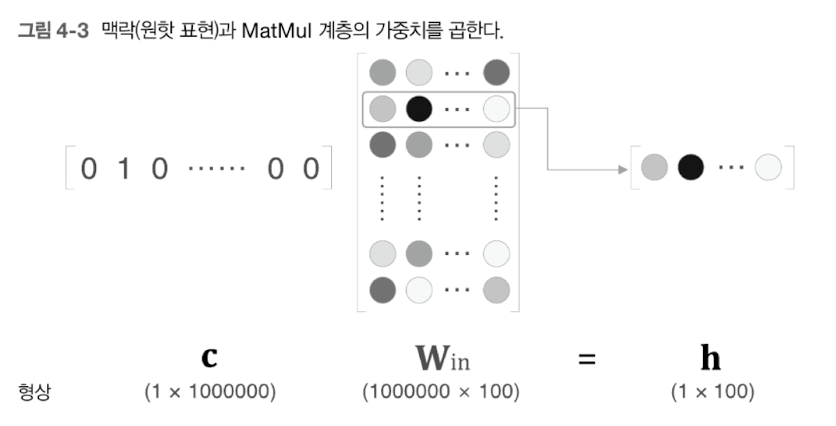

too many useless info fo Weight   
what we need? : row vector of specific context in Weight Matrix

=> from Weight M - extract word_id vector 
= Embedding 

In [ ]:
import numpy as np
W = np.arange(21).reshape(7,3)
W

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])

In [ ]:
# extract 2nd vector
print(W[2])

#extract 5th vector
print(W[5])

#all at once

idx = np.array([2,3,5])
print(W[idx])

[6 7 8]
[15 16 17]
[[ 6  7  8]
 [ 9 10 11]
 [15 16 17]]


In [ ]:
params = [W]
W, = params

params, W

([array([[ 0,  1,  2],
         [ 3,  4,  5],
         [ 6,  7,  8],
         [ 9, 10, 11],
         [12, 13, 14],
         [15, 16, 17],
         [18, 19, 20]])],
 array([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17],
        [18, 19, 20]]))

In [ ]:
# Embedding : from W, extract idx rows

class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params 
        self.idx = idx
        out = W[idx]
        return out

    # backward
    # just pass grad from outlayer backward

    def backward(self,dout):
        dW, = self.grads
        dW[...] = 0 # all elements into zeros
        
        for i, word_id in enumerate(self.idx): # for duplicates 
            dW[word_id] += dout[i]

        # or 
        # np.add.at(dW, self.idx, dout) 
        # add dout to dW's self.idx row 
        return None

In [ ]:
print(W)
print(idx)

E = Embedding(W)
print(E.params)
print("before grad update:",E.grads)
out = E.forward(np.array([2,3,5]))
print(E)

E.backward(out)
print("after grad update:",E.grads)


[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]]
[2 3 5]
[array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])]
before grad update: [array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])]
after grad update: [array([[ 0,  0,  0],
       [ 0,  0,  0],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [ 0,  0,  0],
       [15, 16, 17],
       [ 0,  0,  0]])]


improve word2vec.  
softmax and matrix multiplication 

what is **negative sampling**? 
= binary classification

*multi-class into binary class problem*

if contexts are ['you' , 'goodbye'], *what's the target word?* (pick from len(vocab_size)]

-> 

if contexts are ['you' , 'goodbye'], *is the target word 'say'? Yes or No* 

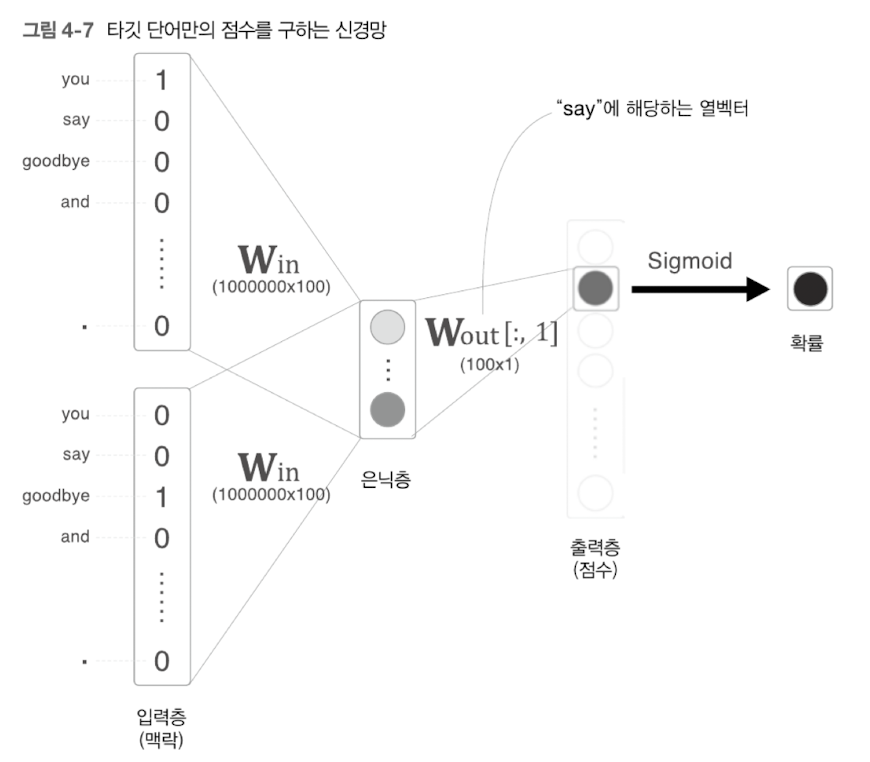

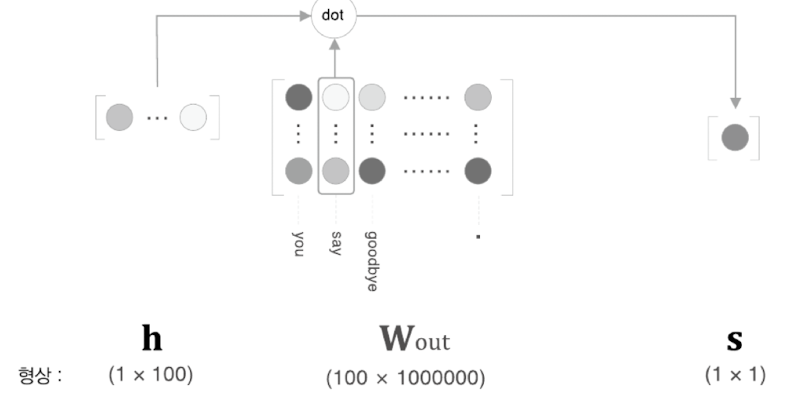

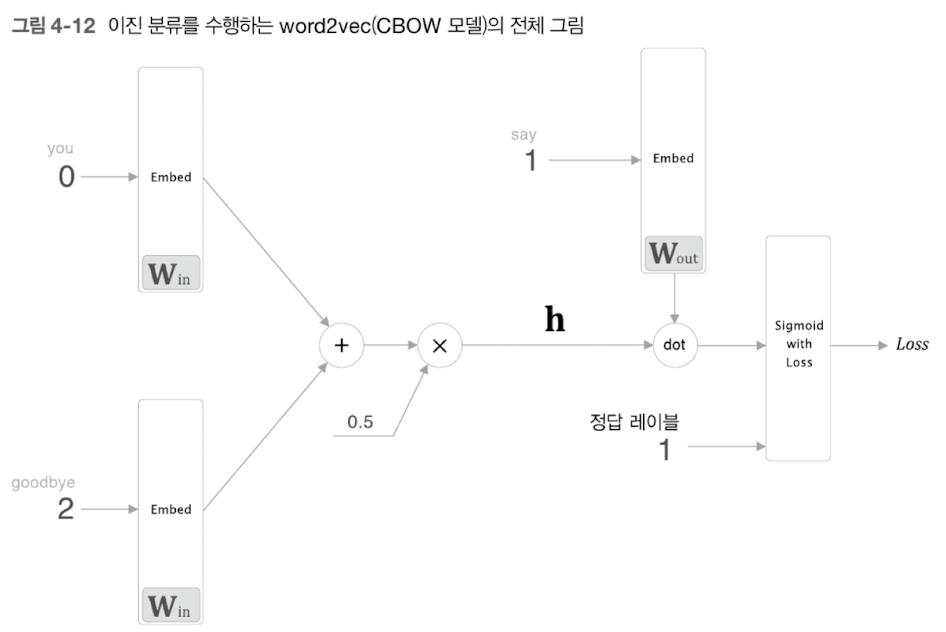

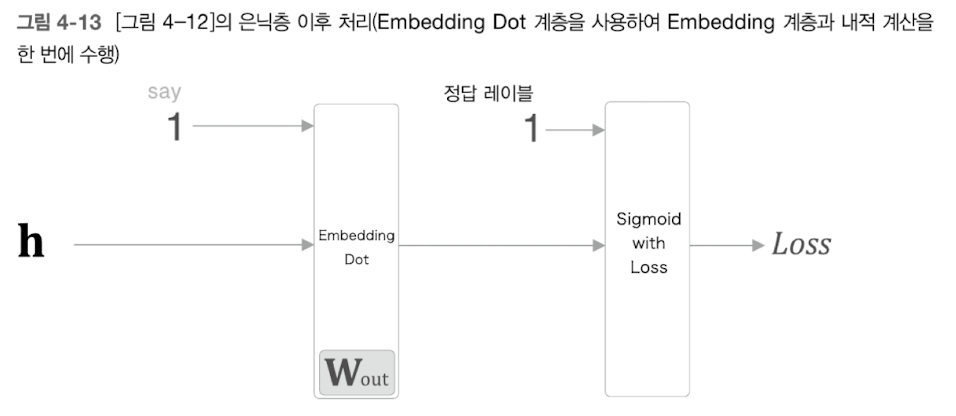

In [ ]:
# negative sampling layer 

class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
    
    def forward(self, h, idx):
        #print("do EmbeddingDot forward..")
        #print('target_W = self.embed.forward(idx)') 
        target_W = self.embed.forward(idx)# embedding of target word 
        #print("h:\n",h , h.shape)
        #print("idx:\n",idx)
        #print("target_W:\n",target_W, target_W.shape)

        out = np.sum(target_W * h, axis=1) 
        #print('out = np.sum(target_W * h, axis=1) ')
        #print("out:\n",out, out.shape)
        # dot product (elementwise mul & sum(axis=1))

        
        self.cache = (h, target_W)
        return out
    
    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout* target_W
        return dh




In [ ]:
weight = np.array([[0,1,2],
                   [9,10,11],
                   [3,4,5]])

h = np.array([[0,1,2],
              [3,4,5],
              [6,7,8]])


print(np.dot(weight, h.T))
print(h.T)
print(np.sum(weight*h, axis=1))


[[  5  14  23]
 [ 32 122 212]
 [ 14  50  86]]
[[0 3 6]
 [1 4 7]
 [2 5 8]]
[  5 122  86]


negative sampling?   

for correct label, output must be close to 1 (0.9999) 

for incorrect label, output must be close to 0 (0.00001)

train for every negative label? -> too much computing ! 

so, **sample negative labels** ! 

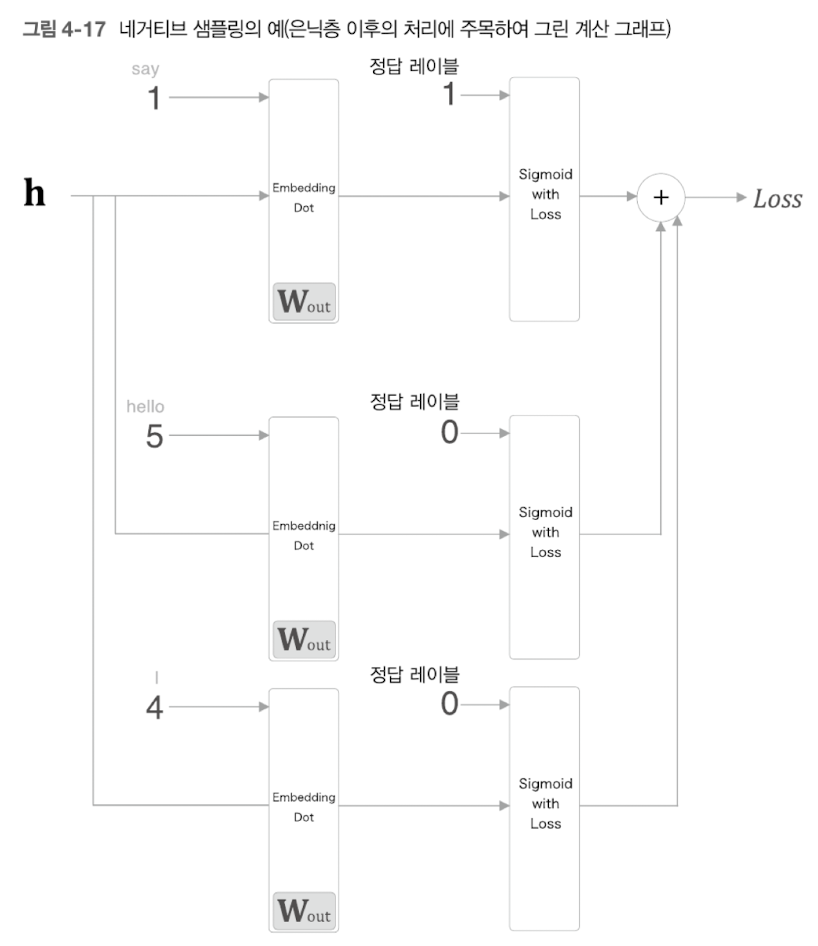

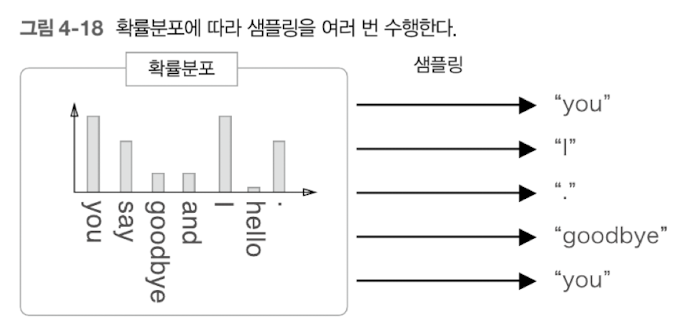

In [ ]:
# sampling negatives

import numpy as np

words = ['you', 'say','goodbye','I','hello','.']
print(np.random.choice(words))

print(np.random.choice(words, size=3, replace=False))


# if corpus prob dist is 
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
print(np.random.choice(words, p=p, size=(2,2)))

# 출현확률이 낮은 단어를 버리지 않기위해 
new_p = np.power(p, 0.75)
new_p /= np.sum(new_p)
print(new_p) 


.
['hello' 'say' 'I']
[['you' 'goodbye']
 ['I' '.']]
[0.40703871 0.12173297 0.07238286 0.20472963 0.07238286 0.12173297]


In [ ]:
# Unigram sampler

import collections

class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] +=1
        
        vocab_size = len(counts)
        self.vocab_size = vocab_size
        
        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i] # probability list same idx with vocab 
        
        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p) # scaled 0.75 word_p

    def get_negative_sample(self, target):
        #print("make negative sample...")
        #print("target:\n", target, target.shape)
        batch_size = target.shape[0]

        #print("random choice from negative sample.. size = (batch, sample_size)")
        negative_sample = np.random.choice(self.vocab_size,
                                           size=(batch_size, self.sample_size),
                                           replace = True,
                                           p = self.word_p)
        #print("negative_sample:\n",negative_sample, negative_sample.shape)

        return negative_sample





In [ ]:
import sys
sys.path.append('..')
from common.util import preprocess, create_contexts_target 

corpus , _ , _ = preprocess('I say good bye and you say hello.')
contexts, target = create_contexts_target(corpus, window_size=1)

n_sampler = UnigramSampler(corpus, 0.75, 2)
n_sampler.get_negative_sample(target)

array([[6, 3],
       [6, 2],
       [0, 7],
       [3, 2],
       [4, 6],
       [3, 2],
       [4, 1]])

In [ ]:
contexts, target

(array([[0, 2],
        [1, 3],
        [2, 4],
        [3, 5],
        [4, 1],
        [5, 6],
        [1, 7]]),
 array([1, 2, 3, 4, 5, 1, 6]))

In [ ]:
#NegativeSamplingLoss
from common.layers import SigmoidWithLoss


class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75,sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)

        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size+1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size+1)]
        """
        sample_size for negative sample, one for positive sample
        """

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, h, target):
        #print("do NSL forward..") 
        batch_size = target.shape[0]
        #print("h:\n", h)
        #print("target:\n",target, target.shape)
        #print("negative_sample = self.sampler.get_negative_sample(target)")
        negative_sample = self.sampler.get_negative_sample(target)

        #positive sample : one
        correct_label = np.ones(batch_size, dtype=np.int32)
        #print('correct_label = np.ones(batch_size, dtype=np.int32)')
        #print("correct_label:\n", correct_label, correct_label.shape)
        score = self.embed_dot_layers[0].forward(h,target)
        #print('score = self.embed_dot_layers[0].forward(h,target)')
        #print("score after embed layer:\n", score, score.shape)
        loss = self.loss_layers[0].forward(score, correct_label)

        #negative sample : sample_size
        negative_label = np.zeros(batch_size, dtype=np.int32)
        #print('negative_label = np.zeros(batch_size, dtype=np.int32)')
        #print('negative_label:\n', negative_label, negative_label.shape)
        
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]# first sample , second_sample .. ith sample 
            #print('negative_target = negative_sample[:, i]') 
            #print(f"{i}th negative_target:\n", negative_target, negative_target.shape)

            score = self.embed_dot_layers[i+1].forward(h, negative_target) # embed_dot_layers[0] is for positive label
            #print('score = self.embed_dot_layers[i+1].forward(h, negative_target)')
            #print(f'{i}th score after negative embed_layer:\n')
            loss += self.loss_layers[i+1].forward(score, negative_label)
            
        return loss

    def backward(self, dout = 1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
        
        return dh 


In [ ]:
# CBOW with embedding & negative sampling 

class CBOWNS:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        """
        window_size: foward_backward contexts
        corpus: word_id list 
        """
        V,H = vocab_size, hidden_size
        #print("vocab_size:", V)
        #print("hidden_size:", H)

        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')
        #print("W_in:", W_in.shape)
        #print("W_out:", W_out.shape)

        self.in_layers = []
        for _ in range(2*window_size):
            layer = Embedding(W_in) # embedding layer: if window_size==2, 2|2 4 
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
        
        layers = self.in_layers + [self.ns_loss] 
        #print("layers in CBOWNS:\n", self.in_layers)
        
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        self.word_vecs = W_in 

    def forward(self, contexts, target):
        #print("contexts:\n", contexts, contexts.shape)
        #print("target:\n", target, target.shape)
        h=0
        for i, layer in enumerate(self.in_layers): 
            # in layers에 모아둔 각 layer들 하나씩 꺼내서 forward 통과시키기
            #print(f'{i}th contexts[:,i]:\n', contexts[:, i],contexts[:, i].shape )
            h += layer.forward(contexts[:,i])
            #print(f'{i}th CBOWNS forward..')
            #print('h += layer.forward(contexts[:,i])')
            #print(f'{i}th h', h, h.shape)
        h *= 1 / len(self.in_layers)
        #print('h *= 1 / len(self.in_layers)')
        #print("h after every layer:\n", h, h.shape)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        
        return None





In [ ]:
import sys
sys.path.append('..')

from common import config 
from common.trainer import Trainer
from common.optimizer import Adam
import pickle
from dataset import ptb



window_size = 2
hidden_size = 5
batch_size = 3
max_epoch = 1

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts , target = create_contexts_target(corpus, window_size)
model = CBOWNS(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()


vocab_size: 10000
hidden_size: 5
W_in: (10000, 5)
W_out: (10000, 5)
layers in CBOWNS:
 [<__main__.Embedding object at 0x7f7aa6ad6400>, <__main__.Embedding object at 0x7f7aa6ad6160>, <__main__.Embedding object at 0x7f7aa6ad6a30>, <__main__.Embedding object at 0x7f7aa5e2e3d0>]
contexts:
 [[ 934  935  383 2541]
 [ 790  352   27  113]
 [2543 2895 5454   32]] (3, 4)
target:
 [ 936 3316  152] (3,)
0th contexts[:,i]:
 [ 934  790 2543] (3,)
0th CBOWNS forward..
h += layer.forward(contexts[:,i])
0th h [[-0.00742563  0.01483581  0.00907562  0.00620338 -0.00275905]
 [-0.01015713 -0.0172452  -0.00600143 -0.01967758 -0.02252271]
 [-0.00203558  0.00169508 -0.0010615  -0.00213822 -0.00604521]] (3, 5)
1th contexts[:,i]:
 [ 935  352 2895] (3,)
1th CBOWNS forward..
h += layer.forward(contexts[:,i])
1th h [[-0.01961069  0.02653943  0.00362252 -0.00296009  0.00792418]
 [-0.01728814 -0.01716095 -0.00860212 -0.0170165  -0.00227673]
 [-0.02704758  0.00497365 -0.00437842  0.00261955 -0.00105804]] (3, 5)
2th c

KeyboardInterrupt: ignored